In [12]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import os
import random
from scipy import misc
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.contrib as tf_contrib
import keras
from keras.datasets import cifar100

In [4]:
(train_data, train_label), (test_data, test_label) = cifar100.load_data()

In [5]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
def normalize(X_train, X_test):

    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_test

train_data, test_data = normalize(train_data, test_data)

#train_label = to_categorical(train_label, 100)
#test_label = to_categorical(test_label, 100)



In [7]:
seed = 777
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_label)

In [8]:
train_label = tf.squeeze(tf.one_hot(train_label, 100),axis=1)
test_label = tf.squeeze(tf.one_hot(test_label, 100),axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


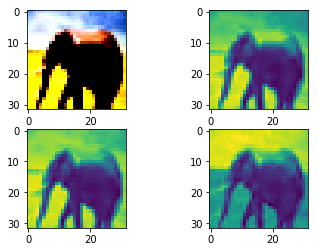

In [51]:
# show data
_, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
sample_data = train_data[0]
ax1.imshow(sample_data);
ax2.imshow(sample_data[:,:,0]);
ax3.imshow(sample_data[:,:,1]);
ax4.imshow(sample_data[:,:,2]);


In [62]:
res_n = [2, 1, 1, 1]
weight_init = tf_contrib.layers.variance_scaling_initializer()
weight_regularizer = tf_contrib.layers.l2_regularizer(0.0001)
def resnet(outs, channels, downsample = False, scope = "resnet"):
    shortcut = outs
    with tf.variable_scope(scope):
        
        outs = tf.layers.batch_normalization(outs,momentum=0.9, epsilon=1e-05)
        outs = tf.nn.relu(outs)
        outs = outs = tf.layers.conv2d(outs, channels, 3, padding = "same")
        outs = tf.layers.batch_normalization(outs, momentum=0.9, epsilon=1e-05)
        outs = tf.nn.relu(outs)
        outs += shortcut
        outs = tf.layers.conv2d(outs, channels, 3, padding = "same")
        #outs += shortcut
        return outs

In [63]:
def model(X, by):
    #nnot feed value ofX = tf.expand_dims(X, axis = 3)
    with tf.variable_scope("first"):
        outs = tf.layers.conv2d(X, 64, 3, strides = (1, 1), padding = "same")
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2)
        #outs = tf.layers.average_pooling2d(outs, 2, 2)
        outs = tf.layers.conv2d(outs, 64, 3, padding = "same")

        outs = tf.reshape(outs, (-1, outs.shape[1] * outs.shape[2] * outs.shape[3]))
    #    outs = tf.layers.dense(outs, 512)
    #    outs = tf.nn.relu(outs)
        outs = tf.layers.dense(outs, 100, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, use_bias=True)

        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = by, logits = outs)
        loss = tf.reduce_mean(loss)

        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)
        #opt = tf.train.MomentumOptimizer(1e-2, momentum=0.9).minimize(loss)
        preds = tf.equal(tf.argmax(tf.nn.softmax(outs), 1), tf.argmax(by, 1))
        acc = tf.reduce_mean(tf.cast(preds, tf.float32))
        #acc = tf.metrics.accuracy(by, preds)
        return {
            "loss" : loss,
            "opt" : opt,
            "preds" : preds,
            "acc" : acc
        }

In [64]:
X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
by = tf.placeholder(tf.float32, shape = [None, 100])

ours = model(X, by)

init = tf.global_variables_initializer()

ValueError: Variable first/conv2d/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-47-eb7f51e466a0>", line 44, in model
    outs = tf.layers.conv2d(X, 64, 3, strides = (1, 1), padding = "same")
  File "<ipython-input-48-ea110bde92d1>", line 4, in <module>
    ours = model(X, by)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [49]:
num_epochs = 100
batch_size = 100
num_display = 100
num_samples = 50000

In [50]:
with tf.Session() as sess:
    sess.run(init)
    for ind_epoch in range(0, num_epochs):
        print("Curent iteration {}".format(ind_epoch +1))
        for ind_ in range(0, int(num_samples/batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label.eval()[ind_*batch_size:(ind_+1)*batch_size]
            
            _, cur_loss, cur_acc = sess.run([ours["opt"], ours["loss"], ours["acc"]], feed_dict = {X : batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print("loss {0:.4f} acc {1:.4f}".format(cur_loss, cur_acc))
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    for ind_ in range(0 , 10):
        cur_loss, cur_acc = sess.run([ours["loss"], ours["acc"]], feed_dict = {X : test_data[ind_ * 1000:(ind_+1) *1000], by : test_label.eval()[ind_ * 1000: (ind_ +1) *1000]})
        cur_acc_all += cur_acc
        cur_loss_all += cur_loss
    print("Test: less {0:.4f} acc {1:.4f}".format(cur_loss_all/ 10.0, cur_acc_all/ 10.0))      
                

Curent iteration 1
loss 4.6048 acc 0.0000
loss 3.8090 acc 0.1100
loss 3.6998 acc 0.0500
loss 3.3694 acc 0.1700
loss 3.5357 acc 0.2200
Curent iteration 2
loss 3.2312 acc 0.2700
loss 3.0958 acc 0.2700
loss 2.9792 acc 0.2100


KeyboardInterrupt: 